# Computing PGS (polygenic risk score)

**Author: Anastazie Sedlakova, PhD, `anastazie` at `sedlakovi.org`**

## Introduction

### Notebook
In this notebook contains code for:
- Generating score file for selected PGS (polygenic risk score) using [pgscatalog-utils](https://github.com/PGScatalog/pgscatalog_utils)
- Transforming myHeritage format to PLINK format using [PLINK](https://www.cog-genomics.org/plink/1.9/)
- Generating scorefile for selected PGS
- Downloading VCF (variant call format) files for selected chromosomes from [1000 genomes](https://www.internationalgenome.org/) project
- Extracting selected varaints using [vcftools](https://vcftools.sourceforge.net/) and concatenating them into one file
- Computing individual and population PGS
- Plotting PGS

### Input files
- Genotyping results, in this example axported file from myHeritage
- Name of the PGS score from [PGS catalogue](https://www.pgscatalog.org/)

### Output fiels
- PNG image with population PGS distribution and individual distribution showed as a vertical line

## Download data from PGS catalogue

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

Download selected PGS score from [PGS catalogue](https://www.pgscatalog.org/). We selected [PGS000854](https://www.pgscatalog.org/score/PGS000854/) - `Type 2 diabetes (based on SNPs associated with beta cell function)`. Beta cells are located in the pancreas that produce and release the hormone insulin to regulate blood sugar levels.

In [29]:
%%bash
download_scorefiles -i PGS000854 -o . -b GRCh37
combine_scorefiles -s PGS*.txt.gz -t GRCh37 -o combined.txt 

## Get score file

Transform myHeritage format to PLINK.

In [41]:
%%bash
plink --23file <(grep -v ^\# MyHeritage_raw_dna_data.csv|sed 1d|tr , \\t|tr -d \") --make-bed --out dna_data

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to dna_data.log.
Options in effect:
  --23file /dev/fd/63
  --make-bed
  --out dna_data

8192 MB RAM detected; reserving 4096 MB for main workspace.
--23file: dna_data-temporary.bed + dna_data-temporary.bim +
dna_data-temporary.fam written.
776 variants with indel calls present.  '--snps-only no-DI' or
--list-23-indels may be useful here.
Inferred sex: male.
609346 variants loaded from .bim file.
1 person (1 male, 0 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1 founder and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997553.
609346 var

treat these as missing.


--make-bed to dna_data.bed + dna_data.bim + dna_data.fam ... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%85%86%87%88%89%90%91%92%93%94%95%96%97%98%99%done.


Check how many variants are overlapping between selected PGS scores and genotype data. 
Because data arefrom the ancestry panel, generally overlap is low, so we lowered `min-overlap` parameter to 0.55. Recommended setting is 0.75.

In [30]:
! match_variants -d myHeritage -s combined.txt -t dna_data.bim --min_overlap 0.55 --outdir .

No output format specified, writing to combined scoring file
pgscatalog_utils.match.filter: 2023-08-29 10:55:28 ERROR    Score PGS002591_hmPOS_GRCh37 fails minimum matching threshold (2.85% variants match)
pgscatalog_utils.match.filter: 2023-08-29 10:55:28 ERROR    Score PGS001281_hmPOS_GRCh37 fails minimum matching threshold (16.00% variants match)
pgscatalog_utils.match.filter: 2023-08-29 10:55:28 ERROR    Score PGS001773_hmPOS_GRCh37 fails minimum matching threshold (0.00% variants match)
pgscatalog_utils.match.filter: 2023-08-29 10:55:28 ERROR    Score PGS001226_hmPOS_GRCh37 fails minimum matching threshold (8.76% variants match)
pgscatalog_utils.match.filter: 2023-08-29 10:55:28 ERROR    Score PGS001097_hmPOS_GRCh37 fails minimum matching threshold (9.52% variants match)
pgscatalog_utils.match.filter: 2023-08-29 10:55:28 ERROR    Score PGS000063_hmPOS_GRCh37 fails minimum matching threshold (37.50% variants match)
pgscatalog_utils.match.filter: 2023-08-29 10:55:28 ERROR    Score P

## Get population data for the selected PGS

In [2]:
# Load scorefile
pgs = pd.read_csv('myHeritage_ALL_additive_0.scorefile', sep='\t')
pgs

,ID,effect_allele,PGS000854_hmPOS_GRCh37
0,rs7756992,G,0.25
1,rs3802177,G,0.75
2,rs11257655,T,0.28
3,rs2334499,T,0.44
4,rs10830961,G,0.38
5,rs12899811,G,0.23
6,rs516946,C,0.82
7,rs10758593,A,0.43
8,rs505922,C,0.32
9,rs5215,C,0.41


In [3]:
# Load genotyping data
variants = pd.read_csv('MyHeritage_raw_dna_data.csv', skiprows=12)
variants.head()

/var/folders/47/z868fb114vbcby_0y6qhdrbr0000gn/T/ipykernel_91972/1218700165.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  variants = pd.read_csv('MyHeritage_raw_dna_data.csv', skiprows=12)


,RSID,CHROMOSOME,POSITION,RESULT
0,rs547237130,1,72526,AA
1,rs562180473,1,565703,AA
2,rs575203260,1,567693,TT
3,rs3131972,1,752721,GG
4,rs200599638,1,752918,GG


In [4]:
# Merge genotyping results and scorefile to compute PGS scores
merged = pd.merge(pgs, variants, how='left', left_on='ID', right_on='RSID')
merged.head()

,ID,effect_allele,PGS000854_hmPOS_GRCh37,RSID,CHROMOSOME,POSITION,RESULT
0,rs7756992,G,0.25,rs7756992,6,20679709,AG
1,rs3802177,G,0.75,rs3802177,8,118185025,AG
2,rs11257655,T,0.28,rs11257655,10,12307894,CT
3,rs2334499,T,0.44,rs2334499,11,1696849,CT
4,rs10830961,G,0.38,rs10830961,11,92694757,AG


Download data from 1000 geomes for each chromosome taht is in the selected PGS.

In [39]:
merged['CHROMOSOME'].unique()

array([6, 8, 10, 11, 15, 9, '20'], dtype=object)

In [40]:
for chrom in merged['CHROMOSOME'].unique():
    ! wget 'http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr{chrom}.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz'

--2023-08-29 11:16:20--  http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr6.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.167
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.193.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 959144250 (915M) [application/x-gzip]
Saving to: ‘ALL.chr6.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz’

ALL.chr6.phase3_sha 100%[===================>] 914,71M  1,94MB/s    in 7m 41s  

2023-08-29 11:24:01 (1,99 MB/s) - ‘ALL.chr6.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz’ saved [959144250/959144250]

--2023-08-29 11:24:02--  http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr8.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.167
Connecting to ftp.

In [17]:
merged

,ID,effect_allele,PGS000854_hmPOS_GRCh37,RSID,CHROMOSOME,POSITION,RESULT
0,rs7756992,G,0.25,rs7756992,6,20679709,AG
1,rs3802177,G,0.75,rs3802177,8,118185025,AG
2,rs11257655,T,0.28,rs11257655,10,12307894,CT
3,rs2334499,T,0.44,rs2334499,11,1696849,CT
4,rs10830961,G,0.38,rs10830961,11,92694757,AG
5,rs12899811,G,0.23,rs12899811,15,91544076,AG
6,rs516946,C,0.82,rs516946,8,41519248,CT
7,rs10758593,A,0.43,rs10758593,9,4292083,AG
8,rs505922,C,0.32,rs505922,9,136149229,CT
9,rs5215,C,0.41,rs5215,11,17408630,CT


Extract selected variants and concatenate them into one file.

In [15]:
merged[['CHROMOSOME', 'POSITION']].to_csv('snps.txt', index=False, header=None, sep='\t')

In [20]:
for chrom in merged['CHROMOSOME'].unique():
    !vcftools --gzvcf 'ALL.chr{chrom}.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz' --positions snps.txt --recode --recode-INFO-all --out '{chrom}_extracted'
    !bgzip '{chrom}_extracted.recode.vcf'
    !tabix '{chrom}_extracted.recode.vcf.gz'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ALL.chr6.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
	--recode-INFO-all
	--out 6_extracted
	--positions snps.txt
	--recode

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...
After filtering, kept 1 out of a possible 5024119 Sites
Run Time = 513.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ALL.chr8.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
	--recode-INFO-all
	--out 8_extracted
	--positions snps.txt
	--recode

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...


After filtering, kept 2 out of a possible 4597105 Sites
Run Time = 379.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ALL.chr10.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
	--recode-INFO-all
	--out 10_extracted
	--positions snps.txt
	--recode

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...
After filtering, kept 2 out of a possible 3992219 Sites
Run Time = 469.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ALL.chr11.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
	--recode-INFO-all
	--out 11_extracted
	--positions snps.txt
	--recode

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...


After filtering, kept 3 out of a possible 4045628 Sites
Run Time = 381.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ALL.chr15.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
	--recode-INFO-all
	--out 15_extracted
	--positions snps.txt
	--recode

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...
After filtering, kept 2 out of a possible 2424689 Sites
Run Time = 209.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ALL.chr9.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
	--recode-INFO-all
	--out 9_extracted
	--positions snps.txt
	--recode

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...


After filtering, kept 3 out of a possible 3560687 Sites
Run Time = 191.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ALL.chr20.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz
	--recode-INFO-all
	--out 20_extracted
	--positions snps.txt
	--recode

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...
After filtering, kept 2 out of a possible 1812841 Sites
Run Time = 150.00 seconds


In [ ]:
!vcf-concat 6_extracted.recode.vcf.gz 8_extracted.recode.vcf.gz 9_extracted.recode.vcf.gz 10_extracted.recode.vcf.gz 11_extracted.recode.vcf.gz 15_extracted.recode.vcf.gz 20_extracted.recode.vcf.gz | bgzip -c > combined.vcf.gz

In [22]:
! vcftools --gzvcf combined.vcf.gz --plink  --out combined


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf combined.vcf.gz
	--out combined
	--plink

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Writing PLINK PED and MAP files ... 
Done.
After filtering, kept 15 out of a possible 15 Sites
Run Time = 3.00 seconds


Extract data in tablef format.

In [25]:
!plink --file combined --recode 'tab' --out combined2

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to combined2.log.
Options in effect:
  --file combined
  --out combined2
  --recode tab

8192 MB RAM detected; reserving 4096 MB for main workspace.


.ped scan complete (for binary autoconversion).
Performing single-pass .bed write (15 variants, 2504 people).
--file: combined2-temporary.bed + combined2-temporary.bim +
combined2-temporary.fam written.
15 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to combined2.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%

## Compute PGS

PGS is computed as weighted sum of effect alleles, where weight is multiplied by effect allele count. Weights are listed in the scorefile.

Load table files generated by PLINK
- `map` file contains information about variants, e.g. chromosome and position
- `ped` files contains sample information and genotype

In [30]:
map_file = pd.read_csv('combined2.map', sep='\t', header=None)
map_file

,0,1,2,3
0,6,6:20679709,0,20679709
1,8,8:41519248,0,41519248
2,8,8:118185025,0,118185025
3,9,9:4292083,0,4292083
4,9,9:22134094,0,22134094
5,9,9:136149229,0,136149229
6,10,10:12307894,0,12307894
7,10,10:94462882,0,94462882
8,11,11:1696849,0,1696849
9,11,11:17408630,0,17408630


In [31]:
ped_file = pd.read_csv('combined2.ped', sep='\t', header=None)
ped_file

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,HG00096,HG00096,0,0,0,-9,A A,T C,G G,G G,...,C T,C C,C C,T C,T T,A G,T C,A G,T T,G G
1,HG00097,HG00097,0,0,0,-9,A A,C C,A G,A G,...,C C,C C,T C,T C,T T,A A,T T,A G,C T,G G
2,HG00099,HG00099,0,0,0,-9,A A,C C,G G,A G,...,T T,C C,T C,C C,C T,A G,T C,A A,T T,A G
3,HG00100,HG00100,0,0,0,-9,A A,C C,G G,G G,...,C T,C C,T C,T C,C T,A A,T T,A G,C T,G G
4,HG00101,HG00101,0,0,0,-9,G G,C C,G G,A G,...,T T,T C,T C,T T,C T,A G,T C,A A,T T,A G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,NA21137,NA21137,0,0,0,-9,A A,C C,G G,A G,...,C T,T C,T C,C C,C C,A G,T C,A G,T T,G G
2500,NA21141,NA21141,0,0,0,-9,A A,T C,A G,A A,...,C C,T C,T T,T C,C T,A A,T C,A A,T T,G G
2501,NA21142,NA21142,0,0,0,-9,A A,C C,A G,A G,...,T T,T C,T C,C C,T T,G G,T C,A A,T T,G G
2502,NA21143,NA21143,0,0,0,-9,A A,C C,A G,A A,...,T T,T T,T T,C C,C T,A G,T T,G G,T T,A G


In [34]:
merged

,ID,effect_allele,PGS000854_hmPOS_GRCh37,RSID,CHROMOSOME,POSITION,RESULT
0,rs7756992,G,0.25,rs7756992,6,20679709,AG
1,rs3802177,G,0.75,rs3802177,8,118185025,AG
2,rs11257655,T,0.28,rs11257655,10,12307894,CT
3,rs2334499,T,0.44,rs2334499,11,1696849,CT
4,rs10830961,G,0.38,rs10830961,11,92694757,AG
5,rs12899811,G,0.23,rs12899811,15,91544076,AG
6,rs516946,C,0.82,rs516946,8,41519248,CT
7,rs10758593,A,0.43,rs10758593,9,4292083,AG
8,rs505922,C,0.32,rs505922,9,136149229,CT
9,rs5215,C,0.41,rs5215,11,17408630,CT


In [113]:
# Compute PGS from myHeritage data
ind_pgs = sum(merged.apply(lambda x: x['RESULT'].count(x['effect_allele']), axis=1) * merged['PGS000854_hmPOS_GRCh37'])
ind_pgs

7.87

In [114]:
# Compute PGS for each sample in 1000 genomes dataset
pop_pgs = pd.DataFrame()
pop_pgs['id'] = ped_file[0]
for i in range(map_file.shape[0]):
    variant = map_file.loc[i, [0, 3]]
    row = merged[(merged['CHROMOSOME'].astype(int) == variant[0]) & (merged['POSITION'] == variant[3])]
    pop_pgs[row['RSID'].values[0]] = ped_file.loc[:, 6+i].str.count(row['effect_allele'].values[0]) * row['PGS000854_hmPOS_GRCh37'].values[0]
pop_pgs

,id,rs7756992,rs516946,rs3802177,rs10758593,rs10811661,rs505922,rs11257655,rs1111875,rs2334499,rs5215,rs10830961,rs4502156,rs12899811,rs17265513,rs4812829
0,HG00096,0.00,0.82,1.50,0.00,1.58,0.32,0.00,1.12,0.44,0.00,0.38,0.52,0.23,0.0,0.00
1,HG00097,0.00,1.64,0.75,0.43,0.00,0.64,0.00,0.56,0.44,0.00,0.00,1.04,0.23,0.2,0.00
2,HG00099,0.00,1.64,1.50,0.43,1.58,0.00,0.00,0.56,0.00,0.41,0.38,0.52,0.00,0.0,0.18
3,HG00100,0.00,1.64,1.50,0.00,1.58,0.32,0.00,0.56,0.44,0.41,0.00,1.04,0.23,0.2,0.00
4,HG00101,0.50,1.64,1.50,0.43,1.58,0.00,0.28,0.56,0.88,0.41,0.38,0.52,0.00,0.0,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,NA21137,0.00,1.64,1.50,0.43,1.58,0.32,0.28,0.56,0.00,0.82,0.38,0.52,0.23,0.0,0.00
2500,NA21141,0.00,0.82,0.75,0.86,1.58,0.64,0.28,0.00,0.44,0.41,0.00,0.52,0.00,0.0,0.00
2501,NA21142,0.00,1.64,0.75,0.43,1.58,0.00,0.28,0.56,0.00,0.00,0.76,0.52,0.00,0.0,0.00
2502,NA21143,0.00,1.64,0.75,0.86,1.58,0.00,0.56,0.00,0.00,0.41,0.38,1.04,0.46,0.0,0.18


## Plot PGS

### PGS scores

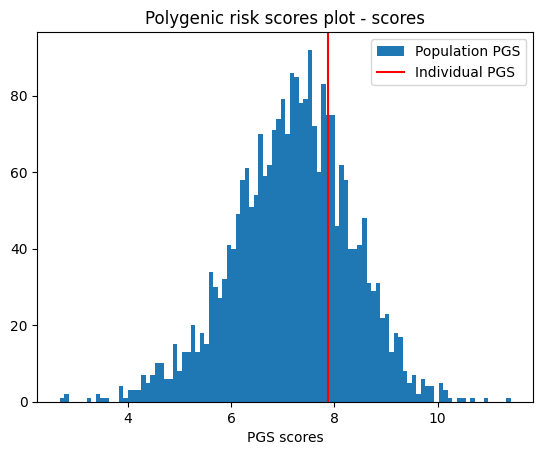

In [136]:
# Plot population PGS and add individual PGS as a vertical line
plt.hist(pop_pgs.iloc[:, 1:].sum(axis=1), label='Population PGS', bins=100)
plt.axvline(ind_pgs, color='r', label='Individual PGS')
plt.legend()
plt.title('Polygenic risk scores plot - scores')
plt.xlabel('PGS scores')
plt.savefig('pgs_plot_scores.png')
plt.show()

### Percentiles

In [131]:
ind_pct = stats.percentileofscore(pop_pgs.iloc[:, 1:].sum(axis=1), ind_pgs)
ind_pct

72.28434504792332

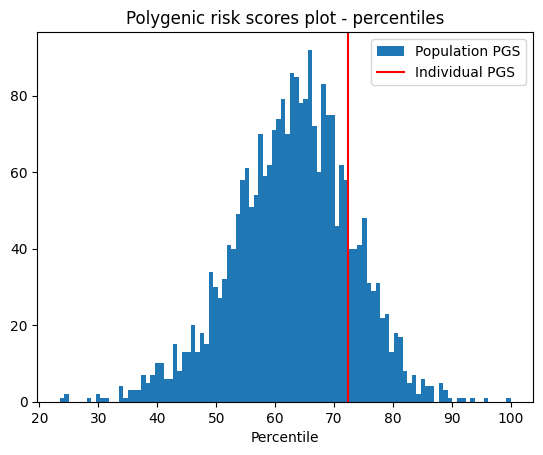

In [137]:
# Plot population PGS and add individual PGS as a vertical line
plt.hist(
    (pop_pgs.iloc[:, 1:].sum(axis=1) / pop_pgs.iloc[:, 1:].sum(axis=1).abs().max())*100, 
    label='Population PGS', bins=100
)
plt.axvline(ind_pct, color='r', label='Individual PGS')
plt.legend()
plt.title('Polygenic risk scores plot - percentiles')
plt.xlabel('Percentile')
plt.savefig('pgs_plot_percentiles.png')
plt.show()